# Prática dados McDonald
   Legendas:
   * <code style="color:green">Teoria</code>
   * <code style="color:purple">Dicas</code>
   * <code style="color:red">Prática (exemplo ou exercício)</code>

Carregando o que será necessário:

In [1]:
import pandas as pd # biblioteca para manipulação de dados
from scipy.spatial.distance import pdist, squareform # funções para calcular as distâncias
from scipy.cluster.hierarchy import linkage, dendrogram,fcluster # funções para clusterização
import matplotlib.pyplot as plt # biblioteca para visualização de dados
import tanglegram # biblioteca para a criação do tanglegram
from sklearn.cluster import AgglomerativeClustering # função para criar os clusters
from sklearn.metrics import silhouette_score, silhouette_samples # função para calcular a silhueta
import numpy as np # biblioteca para calculo
from sklearn.preprocessing import StandardScaler #para colocar os dados na mesma escala
from sklearn.decomposition import PCA # função para realizar o PCA
import seaborn as sns  # biblioteca para visualização de dados
from scipy import stats # biblioteca para análise estatistica
from sklearn.cluster import KMeans
from pandas.plotting import parallel_coordinates #grafico de analise dos clusters
from yellowbrick.cluster import SilhouetteVisualizer #silhueta ponto a ponto
from IPython.core.display import display, HTML #aumentar display para vários gráficos
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

### <code style="color:purple">Carregando todas as funções necessárias </code> 

Todas as funções que serão inicializadas:
    
    - mesma_escala: coloca os dados na mesma escala
    - fazer_dendograma: faz o dendograma
    - calcular_soma_quadrados_totais: função que calcula o wss para cada definição de grupos
    - grafico_elbow: função que faz o gráfico Elbow
    - s_silhouette: cria todas as medidas necessárias para silhueta
    - grafico_silhouette_por_ponto: faz o gráfico da silhueta para o s de cada ponto
    - grafico_silhouette_sugestao_grupos: faz o gráfico da silhueta para sugestão de número de grupos

O detalhamento de seus parâmetros e retornos estão comentados acima de cada função

In [2]:
#Esta função coloca os dados na mesma escala usando a equacao padrao
# (x-xbarra)/sd
# só criei isso porque o Scaler do python divide pelo desvio padrao populacional e não amostral
# em conjuntos não tão grande, isso dá muita diferença
#Parâmetros:
# -data: Conjunto de dados.
#Retorna: Conjunto de dados na mesma escala.

def mesma_escala(data):
    data_pad = data.copy()
    for col in data_pad.columns:
        if pd.api.types.is_numeric_dtype(data_pad[col]):
            data_pad[col] = (data_pad[col] - data_pad[col].mean()) / data_pad[col].std(ddof=1)
    return data_pad

# Exemplo de uso
# mesma_escala(mcdonalds)

In [3]:
#Esta função cria o gráfico do dendograma conforme o método escolhido
#Parâmetros:
# -data: Conjunto de dados.
# -metodo: Método de ligação a ser utilizado na clusterização hierárquica (ex: 'average', 'ward', 'complete', 'single', 'centroid').
# -padronizar: Se seus dados não precisam ser padronizados escolher False, caso contrário, True
#Retorna:Apenas exibe o dendrograma.

def fazer_dendograma(data, metodo, padronizar):
    # Padronizando os dados, se padronizar for True
    if padronizar:
        def mesma_escala(data):
            data_pad = data.copy()  
            for col in data_pad.columns:
                if pd.api.types.is_numeric_dtype(data_pad[col]):
                    data_pad[col] = (data_pad[col] - data_pad[col].mean()) / data_pad[col].std(ddof=1)
            return data_pad
        base_padronizada = mesma_escala(data)
#        print("Base padronizada:")
#        print(base_padronizada.head())
        
        # Calculando a matriz de distâncias com os dados padronizados
        d = pdist(base_padronizada, metric='euclidean')
#        print("Matriz de distâncias (padronizada):")
        matriz = squareform(d)
    else:
#        print("Utilizando a base original:")
#        print(data.head())
        
        # Calculando a matriz de distâncias com os dados originais
        d = pdist(data, metric='euclidean')
#        print("Matriz de distâncias (original):")
        matriz = squareform(d)
    
    # Aplicando o linkage (clustering hierárquico)
    cluster_hierarquico = linkage(d, method=metodo)
    
    # Plotando o dendrograma
    plt.figure(figsize=(5, 3))
    plt.title(f"Dendrograma usando {metodo.capitalize()} linkage")
    
    # Exibindo o dendrograma com os rótulos da base de dados
    dendrogram(cluster_hierarquico, labels=data.index)
    
    # Rotacionando os rótulos no eixo x
    plt.xticks(rotation=90)
    
    # Exibindo o gráfico
    plt.show()

# Exemplo de uso
# fazer_dendograma(mcdonalds, metodo='single', padronizar=True)


In [4]:
#Esta função calcula a soma dos quadrados totais (SQT) para cada variável dentro de cada cluster.
# Retorna o calculo passo a passo e uma tabela com a SQT de cada variável,
# além do valor total da soma dos quadrados.
#Parâmetros:
#    - data: Conjunto de dados.
#    - grupos: Um vetor que indica a qual cluster cada observação pertence.
#    - verbose: Se True, imprime informações detalhadas sobre o cálculo.
#Retorna:
#    - Uma tabela com a SQT de cada variável por cluster.
#    - O valor total da soma dos quadrados (WSS).

def calcular_soma_quadrados_totais(data, grupos, verbose):

    sqt_total = 0
    resultado = []

    if verbose:
        print(f"Dados recebidos: \n{data}")
        print(f"Grupos recebidos: \n{grupos}")
    
    # Percorrendo cluster a cluster (grupo a grupo)
    for cluster_gerado in np.unique(grupos):
        if verbose:
            print(f"\nProcessando o cluster {cluster_gerado}...")
        
        # Filtrando os dados do cluster atual
        cluster_data = data[grupos == cluster_gerado]
        
        if verbose:
            print(f"Dados do cluster {cluster_gerado}: \n{cluster_data}")
        
        # Verificando se o cluster tem pelo menos 1 ponto
        if len(cluster_data) > 0:
            # Calculando o centroide (média de cada variável)
            centroide = np.mean(cluster_data, axis=0)
            if verbose:
                print(f"Centroide do cluster {cluster_gerado}: \n{centroide}")
            
            # Calculando a soma dos quadrados para cada variável
            sqt_variaveis = np.sum((cluster_data - centroide) ** 2, axis=0)
            if verbose:
                print(f"SQT das variáveis para o cluster {cluster_gerado}: \n{sqt_variaveis}")
            
            # Armazenando o resultado para cada cluster e variável
            resultado.append(sqt_variaveis)
            
            # Soma dos quadrados dentro do cluster (WSS para o cluster)
            sqt_total += np.sum(np.linalg.norm(cluster_data - centroide, axis=1)**2)
        else:
            resultado.append([np.nan] * data.shape[1])  # Caso de cluster vazio
    
    # Convertendo o resultado para um DataFrame
    df_resultado = pd.DataFrame(np.vstack(resultado), columns=[f'Variável {i+1}' for i in range(data.shape[1])])
    df_resultado.index = [f'Cluster {int(c)}' for c in np.unique(grupos)]
    
    if verbose:
        # Imprimindo o valor total da soma dos quadrados
        print(f"\nSoma total dos quadrados (WSS): {sqt_total}")
    
    return df_resultado, sqt_total

# Exemplo de uso
#roda o método que te interessa
#mcdonalds_padronizado = mesma_escala(mcdonalds)
#d = pdist(mcdonalds_padronizado, metric='euclidean')
#cluster_hierarquico = linkage(d, method='single')
#marca os grupos
#grupos = fcluster(cluster_hierarquico , t=2, criterion='maxclust')
#grupos
#chama a função
#df_resultado, wss_total = calcular_soma_quadrados_totais(mcdonalds_padronizado, grupos, verbose=True)
# Exibir a tabela de resultados
#print(df_resultado)
#print(f"\nSoma total dos quadrados (WSS):", wss_total)
#print(grupos)

In [5]:
#Esta função faz o cluster hierárquico com o método definido, calcula a soma dos quadrados totais (SQT)
#para diferentes números de clusters e plota o gráfico do método do cotovelo (Elbow).
#Parâmetros:
# - data: Conjunto de dados.
# - metodo: Método de ligação a ser utilizado na clusterização hierárquica (ex: 'average', 'ward', 'complete', 'single', 'centroid').
# - max_clusters: O número máximo de clusters a ser considerado no cálculo, ou seja, vai calcular para todos os clusters até este valor.
# - padronizar: Se seus dados não precisam ser padronizados escolher False, caso contrário, True
# importante documentar que se os dados forem padronizados (necessário quando tem escalas diferentes)
# o SQT será calculado com os dados padronizados.
#Retorna:
#    - Plota o gráfico do método do cotovelo para o número de clusters.

def grafico_elbow(data, metodo, max_clusters, padronizar):
    # Verifica se os dados devem ser padronizados
    if padronizar:
        def mesma_escala(data):
            data_pad = data.copy() 
            for col in data_pad.columns:
                if pd.api.types.is_numeric_dtype(data_pad[col]):
                    data_pad[col] = (data_pad[col] - data_pad[col].mean()) / data_pad[col].std(ddof=1)
            return data_pad
        data_utilizado = mesma_escala(data)
    else:
        print("Usando os dados originais...")
        data_utilizado = data
    
    # Criar o linkage (cluster_hierarquico) com o método especificado
    cluster_hierarquico = linkage(data_utilizado, method=metodo)
    
    # Lista para armazenar os valores de SQT
    sqt = []
    
    # Calcular SQT para diferentes números de clusters
    for n_clusters in range(1, max_clusters + 1):
        grupos = fcluster(cluster_hierarquico, t=n_clusters, criterion='maxclust')
        
        if n_clusters > 1:
            # A função 'calcular_soma_quadrados_totais' retorna dois valores, o WSS 
            # está na segunda posição
            _, wss_total = calcular_soma_quadrados_totais(data_utilizado, grupos, verbose=False)
            sqt.append(wss_total)
        else:
            sqt.append(np.nan)  # Para o caso de n_clusters = 1
    
    # Plotar o gráfico do método do cotovelo (Elbow)
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, max_clusters + 1), sqt, marker='o')
    plt.xlabel('Número de Clusters')
    plt.ylabel('Soma dos Quadrados das Distâncias')
    plt.title(f'Elbow para Clustering Hierárquico pelo método {metodo.capitalize()}')
    plt.show()

# Exemplo de uso
#grafico_elbow(mcdonalds, metodo='average', max_clusters=10, padronizar = False)

In [6]:
#Esta função faz o cluster hierárquico com o método definido e calcula o a_i, b_i, s_i, s_k para cada k cluster criados
#a ideia aqui é ter uma função que faz todas as contas necessárias para silhueta, a fim de armazenar um df.
#Parâmetros:
# - data: Conjunto de dados.
# - metodo: Método de ligação a ser utilizado na clusterização hierárquica (ex: 'average', 'ward', 'complete', 'single', 'centroid').
# - max_clusters: O número máximo de clusters a ser considerado no cálculo, ou seja, vai calcular para todos os clusters até este valor.
# - padronizar: Se seus dados não precisam ser padronizados escolher False, caso contrário, True
# importante documentar que se os dados forem padronizados (necessário quando tem escalas diferentes)
# a silhueta será calculado com os dados padronizados.
#Retorna:
#    - df_silhueta: DataFrame contendo os resultados (label_ponto, grupo, a_i, b_i, s_i, s_k, k).

def s_silhouette(data, metodo, max_clusters, padronizar):

    # Se padronizar for True, padroniza os dados
    if padronizar:
        def mesma_escala(data):
            data_pad = data.copy()  
            for col in data_pad.columns:
                if pd.api.types.is_numeric_dtype(data_pad[col]):
                    data_pad[col] = (data_pad[col] - data_pad[col].mean()) / data_pad[col].std(ddof=1)
            return data_pad
        data_padronizada = mesma_escala(data)
        d = pdist(data_padronizada, metric='euclidean')
        print("Dados padronizados para clustering")
    else:
        d = pdist(data, metric='euclidean')
        print("Dados originais utilizados para clustering")
    
    # Convertendo a matriz de distâncias para formato quadrado (necessária para silhouette)
    d_square = squareform(d)
    
    # Criando a lista para armazenar os resultados de cada k
    silhueta = []
    
    # Rodando o clustering hierárquico uma vez
    cluster_hierarquico = linkage(d, method=metodo)

    # Iterando para cada valor de k (de 2 até max_clusters)
    for k in range(2, max_clusters + 1):
        grupos = fcluster(cluster_hierarquico, t=k, criterion='maxclust')

        # Calculando a e b para cada ponto usando a função calc_a_b
        a_vals, b_vals = calc_a_b(d_square, grupos, np.unique(grupos))

        # Calculando silhouette para cada ponto, com a regra de cluster único
        silhouette_vals = []
        for a_i, b_i, grupo in zip(a_vals, b_vals, grupos):
            # Se o ponto está sozinho no cluster, defina silhueta como 0
            if np.sum(grupos == grupo) == 1:
                silhouette_vals.append(0)
            else:
                silhouette_vals.append((b_i - a_i) / max(a_i, b_i) if max(a_i, b_i) != 0 else 0)

        # Calculando a média das silhuetas
        silhouette_avg = np.mean(silhouette_vals)

        # Criando DataFrame temporário para armazenar os resultados
        df_k = pd.DataFrame({
            'label_ponto': data.index,
            'grupo': grupos,
            'a_i': a_vals,
            'b_i': b_vals,
            's_i': silhouette_vals,
            's_k': silhouette_avg,
            'k': [k] * len(grupos)  # Adiciona o valor de k em todas as linhas
        })

        # Adiciona o DataFrame resultante na lista de resultados
        silhueta.append(df_k)
    
    # Concatenando todos os DataFrames gerados para cada valor de k
    df_silhueta = pd.concat(silhueta, ignore_index=True)

    return df_silhueta


# Função para calcular as distâncias intra-cluster (a) e inter-cluster (b)
def calc_a_b(d_matrix, clusters, cluster_id):
    a_values = []
    b_values = []
    for i in range(len(clusters)):
        same_cluster = np.where(clusters == clusters[i])[0]
        other_clusters = np.where(clusters != clusters[i])[0]
        
        # Distância média para o mesmo cluster (a)
        if len(same_cluster) > 1:
            a = np.mean([d_matrix[i, j] for j in same_cluster if i != j])
        else:
            a = 0  # Se não houver outro ponto no cluster, a = 0
        a_values.append(a)
        
        # Distância média para o cluster mais próximo (b)
        b = np.min([np.mean([d_matrix[i, j] for j in np.where(clusters == c)[0]]) 
                    for c in np.unique(clusters) if c != clusters[i]])
        b_values.append(b)
    
    return a_values, b_values

# Exemplo de uso
#df_silhueta = s_silhouette(mcdonalds, metodo='average', max_clusters=11, padronizar=True)
#df_silhueta

In [7]:
#Esta função cria o gráfico da silhueta para o s de cada ponto
#Parâmetros:
#  df_silhueta : DataFrame obtido na função anterior contendo os resultados de silhueta para cada número de clusters.
#Retorna: Apenas exibe o gráfico da silhueta.

def grafico_silhouette_por_ponto(df_silhueta):
    # Obter os valores únicos de k
    k_values = df_silhueta['k'].unique()
    
    # Definir o número de colunas para o layout dos gráficos
    num_cols = len(k_values)
    
    # Criar um gráfico para cada valor de k
    fig, axes = plt.subplots(1, num_cols, figsize=(15, 6), sharey=False)
    
    # Caso tenha apenas 1 valor de k, evitar erro na iteração
    if num_cols == 1:
        axes = [axes]  # Transformar o único eixo em lista

    for i, k in enumerate(k_values):
        # Filtrar o dataframe para o valor de k
        df_k = df_silhueta[df_silhueta['k'] == k]
        
        # Criar gráfico de barras horizontais sem ordenar os valores
        axes[i].barh(df_k['label_ponto'], df_k['s_i'], color='lightblue', edgecolor='black')
        
        # Adicionar linha pontilhada para o valor de s_k
        axes[i].axvline(x=df_k['s_k'].values[0], color='red', linestyle='--', label=f's_k = {df_k["s_k"].values[0]:.3f}')
        
        # Adicionar linha pontilhada para a média
        axes[i].axvline(x=0, color='blue', linestyle='-')
        
        # Definir título e labels
        axes[i].set_title(f'k = {k}')
        axes[i].set_xlabel('Valor de s_i')
        
        # Mostrar as labels do eixo y para todos os gráficos
#        axes[i].set_yticks(df_k['label_ponto'])
#        axes[i].set_yticklabels(df_k['label_ponto'])
 
        # Mostrar as labels do eixo Y apenas no primeiro gráfico
        if i == 0:
            axes[i].set_yticks(df_k['label_ponto'])
            axes[i].set_yticklabels(df_k['label_ponto'])
        else:
            axes[i].set_yticks([])
            axes[i].set_yticklabels([])
            
    # Ajustar layout
    plt.tight_layout()
    plt.show()

# Exemplo de uso
#grafico_silhouette_por_ponto(df_silhueta)


In [8]:
#Esta função cria o gráfico da silhueta para sugestão de número de grupos
#Parâmetros:
#  df_silhueta : DataFrame obtido na função anterior contendo os resultados de silhueta para cada número de clusters.
#Retorna: Apenas exibe o gráfico da silhueta.

def grafico_silhouette_sugestao_grupos(df_silhueta):
    # Encontrar o valor máximo de s_k
    max_s_k = df_silhueta['s_k'].max()
    
    # Encontrar o menor k correspondente ao maior valor de s_k
    min_k_with_max_s_k = df_silhueta[df_silhueta['s_k'] == max_s_k]['k'].min()
    
    # Plotar o gráfico
    plt.figure(figsize=(10, 6))
    plt.plot(df_silhueta['k'], df_silhueta['s_k'], marker='o', linestyle='-', color='b')
    
    # Adicionar uma linha vertical pontilhada no menor k com s_k máximo
    plt.axvline(x=min_k_with_max_s_k, color='r', linestyle='--', label=f'k = {min_k_with_max_s_k}')
    
    # Títulos e rótulos dos eixos
    plt.title('Gráfico da Silhueta')
    plt.xlabel('Número de clusters (k)')
    plt.ylabel('Silhueta')
    
    # Adicionar legenda
    plt.legend()
    
    # Mostrar o gráfico
    plt.show()

# Exemplo de uso
#grafico_silhouette_sugestao_grupos(df_silhueta)


### <code style="color:purple">Dados</code> 

Importando e trabalhando no conjunto de dados:

In [9]:
# importando o arquivo
#mcdonalds = pd.read_excel("C:/Users/adria/Documents/1_Scripts_Python/IDA_organizado/Analise_Cluster/dados/teste_mcdonald_5.xlsx")
mcdonalds = pd.read_csv("dados/MCDONALDS.csv", sep = ";", decimal = ",")
#colocando o nome do lanche como índice
mcdonalds.set_index(mcdonalds.columns[0], inplace=True)
#poderia fazer assim tambem
#mcdonalds.index = mcdonalds["Lanche"]
#mcdonalds = mcdonalds.drop(["Lanche"],axis = 1)
mcdonalds.head()

,Valor Energetico,Carboidratos,Proteinas,Gorduras Totais,Gorduras Saturadas,Gorduras Trans,Colesterol,Fibra Alimentar,Sodio,Calcio,Ferro
Lanche,,,,,,,,,,,
Big Mac,504,41,25,27.0,12.0,0.5,54,3.5,960,162,6.5
Big Tasty,843,45,41,55.0,24.0,1.7,104,5.1,1511,381,8.2
Quarterao,558,36,31,32.0,16.0,1.3,86,3.6,1216,275,10.0
Mcnifico Bacon,625,38,34,37.0,16.0,1.3,95,3.9,1255,209,11.0
Cheddar McMelt,507,33,29,29.0,14.0,1.2,81,2.9,819,199,10.0


### <code style="color:purple">Funções criadas para método Hierárquico </code> 

Deixando à mão como chamar cada função:
    
    - mesma_escala: coloca os dados na mesma escala
    mesma_escala(mcdonalds)
    
    - fazer_dendograma: faz o dendograma
    fazer_dendograma(mcdonalds, metodo='single', padronizar=True)
    
    - calcular_soma_quadrados_totais: função que calcula o wss para cada definição de grupos
    
    - grafico_elbow: função que faz o gráfico Elbow
    grafico_elbow(mcdonalds, metodo='average', max_clusters=10, padronizar = True)
    
    - s_silhouette: cria todas as medidas necessárias para silhueta
    df_silhueta = s_silhouette(mcdonalds, metodo='average', max_clusters=10, padronizar=True)
    
    - grafico_silhouette_por_ponto: faz o gráfico da silhueta para o s de cada ponto
    grafico_silhouette_por_ponto(df_silhueta)
    
    - grafico_silhouette_sugestao_grupos: faz o gráfico da silhueta para sugestão de número de grupos
    grafico_silhouette_sugestao_grupos(df_silhueta)

### <code style="color:purple">Método Hierárquico vizinho mais próximo </code> 

Vou começar investigando bem o comportamento do método hierárquico - single:

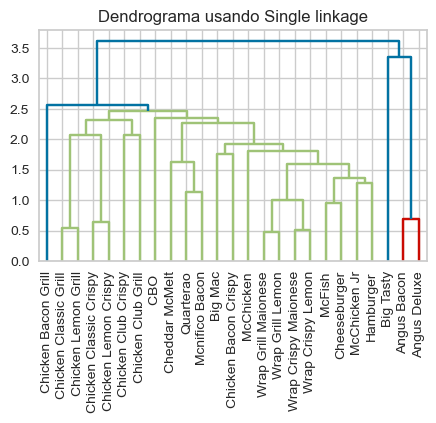

In [10]:
#observando o dendograma
fazer_dendograma(mcdonalds, metodo='single', padronizar=True)

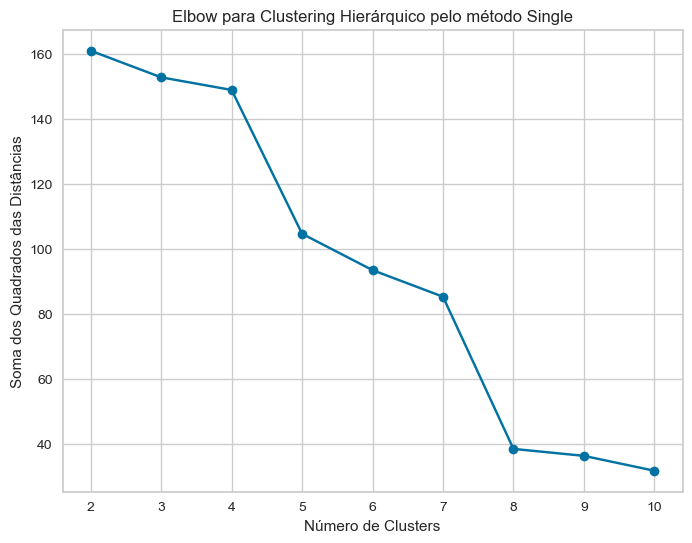

In [12]:
#gráfico Elbow
grafico_elbow(mcdonalds, metodo='single', max_clusters=10, padronizar = True)

In [13]:
#criando as medidas de silhueta
df_silhueta_single = s_silhouette(mcdonalds, metodo='single', \
                                                        max_clusters=10, padronizar=True)
df_silhueta_single[df_silhueta_single['k']==3]

Dados padronizados para clustering


,label_ponto,grupo,a_i,b_i,s_i,s_k,k
25,Big Mac,1,2.974326,5.657850,0.474301,0.420478,3
26,Big Tasty,3,0.000000,3.518239,0.000000,0.420478,3
27,Quarterao,1,4.494280,3.688233,-0.179349,0.420478,3
28,Mcnifico Bacon,1,4.691065,3.612392,-0.229942,0.420478,3
29,Cheddar McMelt,1,4.102946,5.008183,0.180751,0.420478,3
30,McFish,1,2.882433,7.370579,0.608927,0.420478,3
31,McChicken,1,2.848851,6.921891,0.588429,0.420478,3
32,McChicken Jr,1,3.446592,8.527151,0.595810,0.420478,3
33,Chicken Classic Crispy,1,3.751634,6.793423,0.447755,0.420478,3
34,Chicken Classic Grill,1,3.379607,6.898200,0.510074,0.420478,3


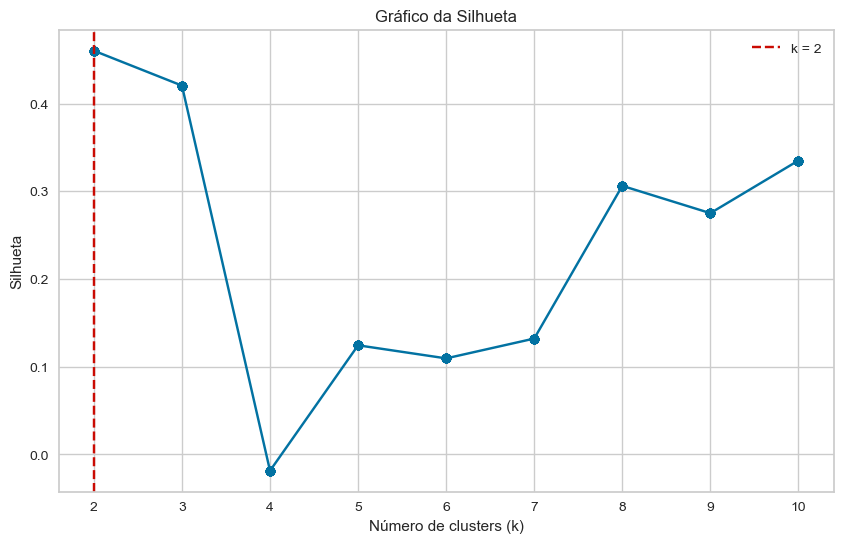

In [14]:
# gráfico da silhueta para sugestão de grupos:
grafico_silhouette_sugestao_grupos(df_silhueta_single)

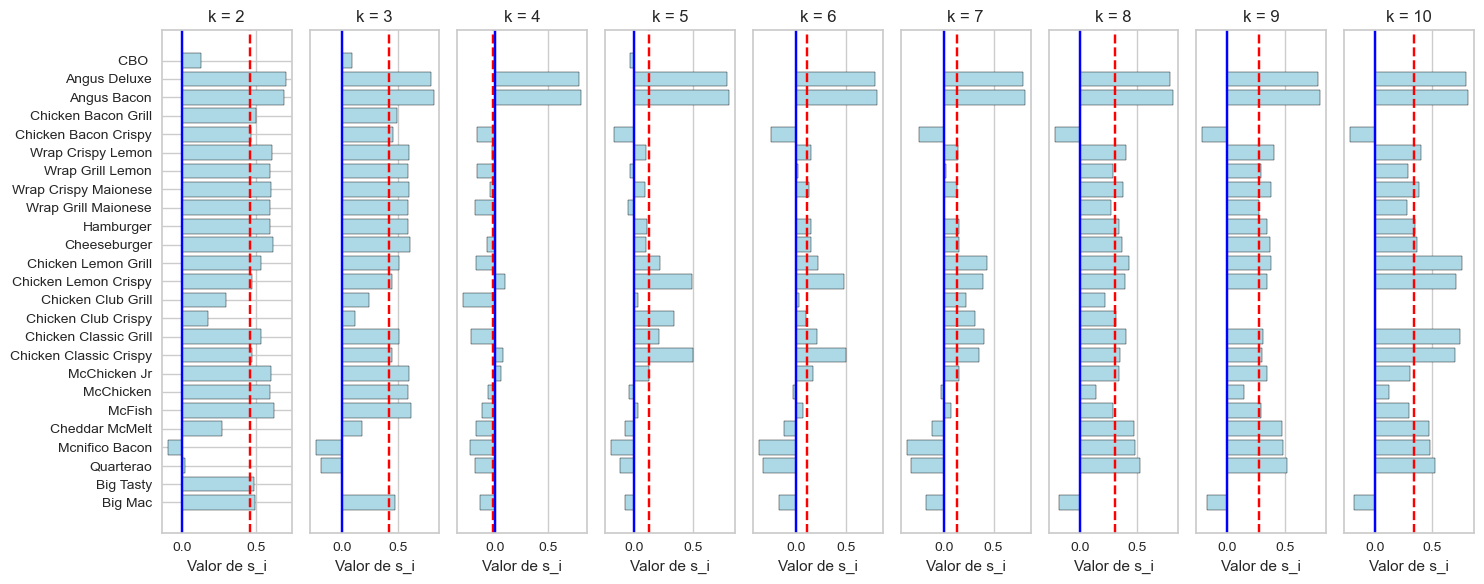

In [15]:
# grafico para ver a silhueta dos pontos conforme essa divisão
grafico_silhouette_por_ponto(df_silhueta_single)

### <code style="color:purple">Método Hierárquico vizinho mais longe </code> 

Vou começar investigando bem o comportamento do método hierárquico - complete:

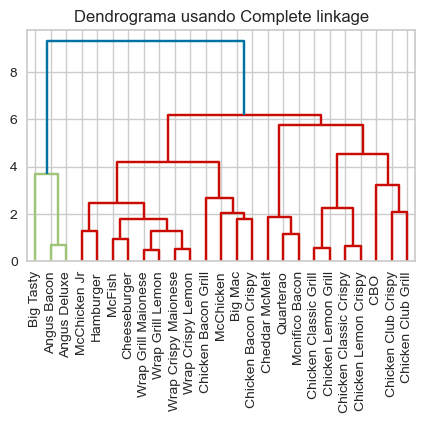

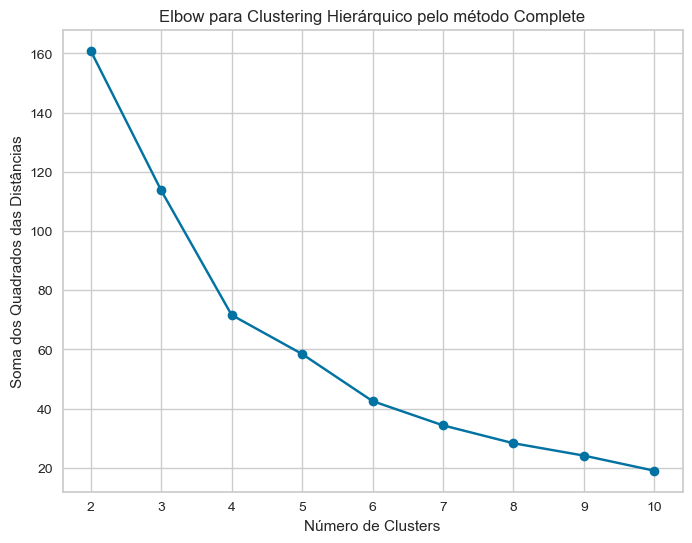

Dados padronizados para clustering


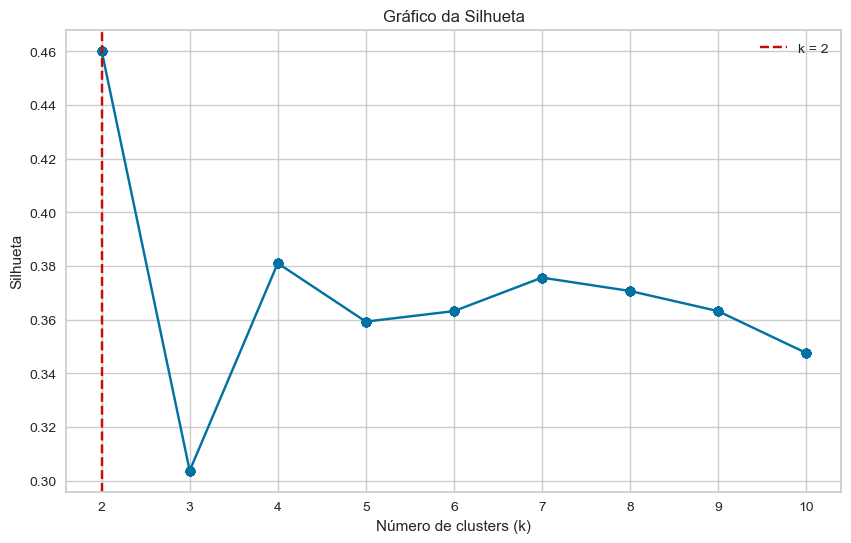

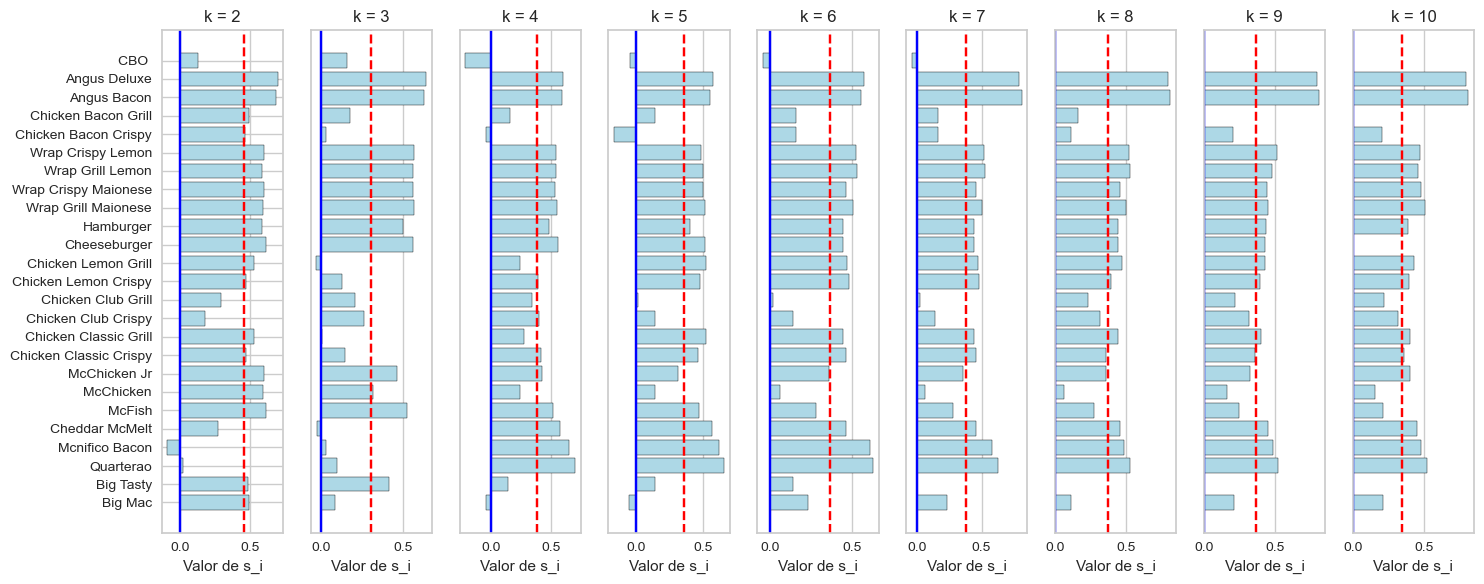

In [16]:
#observando o dendograma
fazer_dendograma(mcdonalds, metodo='complete', padronizar=True)

#gráfico Elbow
grafico_elbow(mcdonalds, metodo='complete', max_clusters=10, padronizar = True)

#criando as medidas de silhueta
df_silhueta_single = s_silhouette(mcdonalds, metodo='complete', \
                                                        max_clusters=10, padronizar=True)

# gráfico da silhueta para sugestão de grupos:
grafico_silhouette_sugestao_grupos(df_silhueta_single)

# grafico para ver a silhueta dos pontos conforme essa divisão
grafico_silhouette_por_ponto(df_silhueta_single)

### <code style="color:purple">Método Hierárquico - Ward </code> 

Vou começar investigando bem o comportamento do método hierárquico - ward:

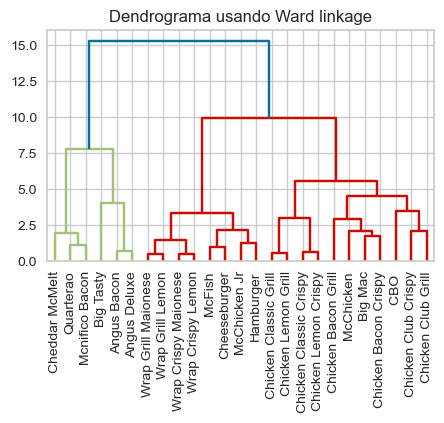

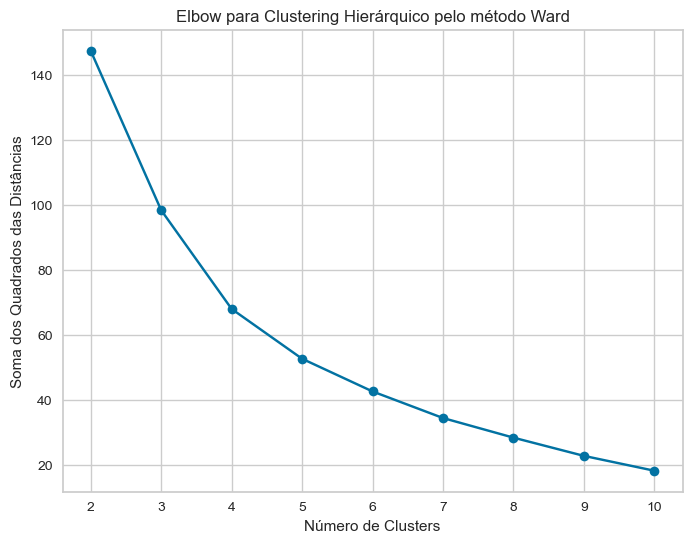

Dados padronizados para clustering


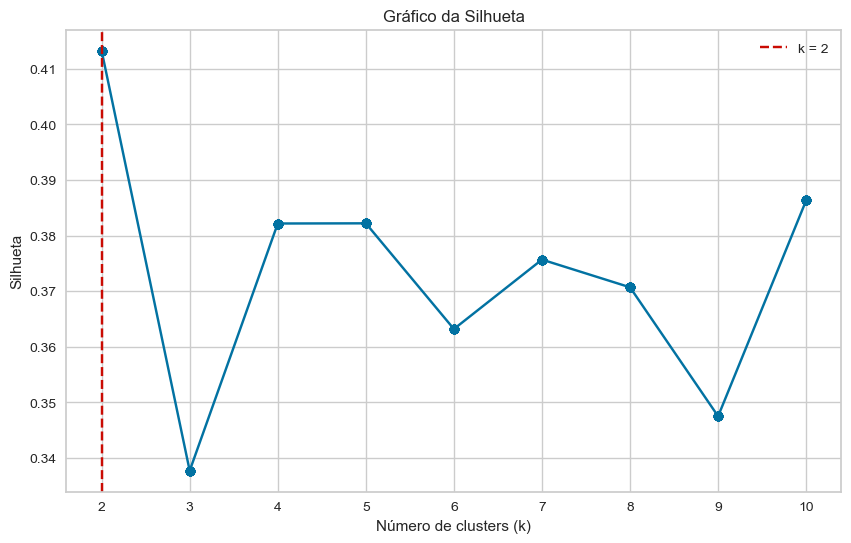

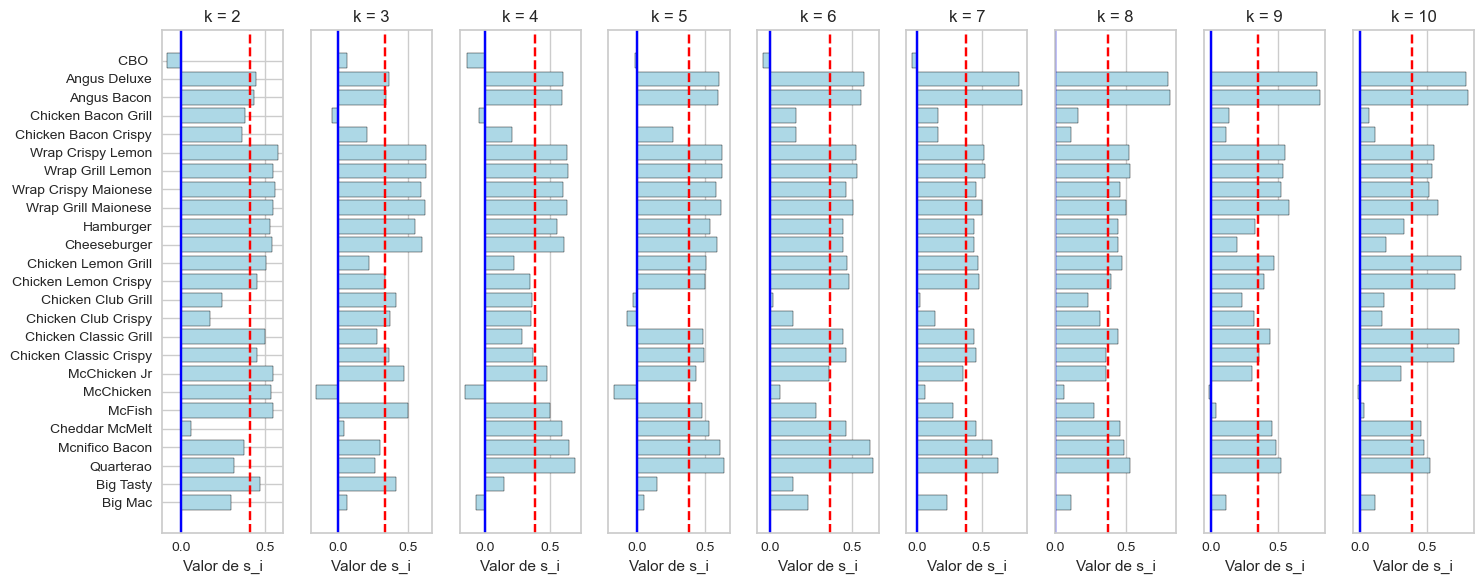

In [17]:
#observando o dendograma
fazer_dendograma(mcdonalds, metodo='ward', padronizar=True)

#gráfico Elbow
grafico_elbow(mcdonalds, metodo='ward', max_clusters=10, padronizar = True)

#criando as medidas de silhueta
df_silhueta_single = s_silhouette(mcdonalds, metodo='ward', \
                                                        max_clusters=10, padronizar=True)

# gráfico da silhueta para sugestão de grupos:
grafico_silhouette_sugestao_grupos(df_silhueta_single)

# grafico para ver a silhueta dos pontos conforme essa divisão
grafico_silhouette_por_ponto(df_silhueta_single)

### <code style="color:purple">Método Não Hierárquico - Kmeans </code> 

Vou começar investigando bem o comportamento do método não hierárquico - kmeans:

In [18]:
#padronizando as variáveis conforme a funçao criada
mcdonalds_pad  = mesma_escala(mcdonalds)
mcdonalds_pad.head()

,Valor Energetico,Carboidratos,Proteinas,Gorduras Totais,Gorduras Saturadas,Gorduras Trans,Colesterol,Fibra Alimentar,Sodio,Calcio,Ferro
Lanche,,,,,,,,,,,
Big Mac,0.059779,-0.038635,-0.221628,0.226372,0.485443,-0.178145,-0.203200,-0.146524,-0.536204,0.132286,0.757381
Big Tasty,2.038786,0.390646,1.163546,2.461354,2.335925,2.048664,1.207912,0.769249,0.980782,2.804862,1.340404
Quarterao,0.375019,-0.575237,0.297812,0.625476,1.102270,1.306395,0.699912,-0.089288,0.168603,1.511287,1.957723
Mcnifico Bacon,0.766150,-0.360596,0.557532,1.024580,1.102270,1.306395,0.953912,0.082419,0.275976,0.705853,2.300677
Cheddar McMelt,0.077292,-0.897197,0.124666,0.386013,0.793857,1.120827,0.558801,-0.489938,-0.924398,0.583818,1.957723


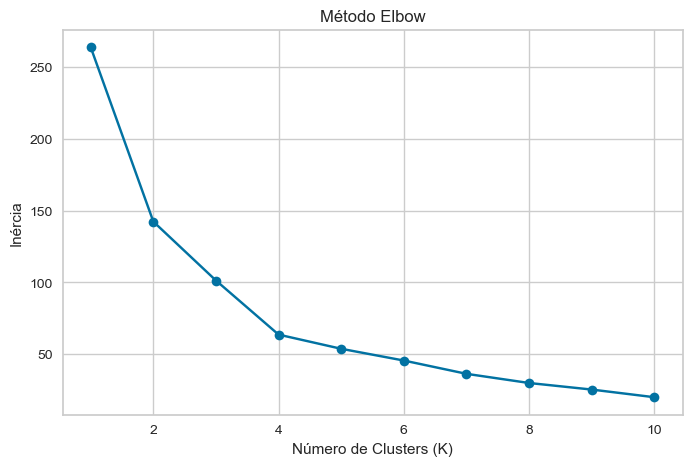

In [19]:
# elbow para método kmeans
lista_soma = [KMeans(n_clusters=cluster, random_state=1987).fit(mcdonalds_pad).inertia_ \
              for cluster in range(1,11)  ]


plt.figure(figsize=(8, 5))
plt.plot(range(1,11), lista_soma, 'bo-')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Inércia')
plt.title('Método Elbow')
plt.show()

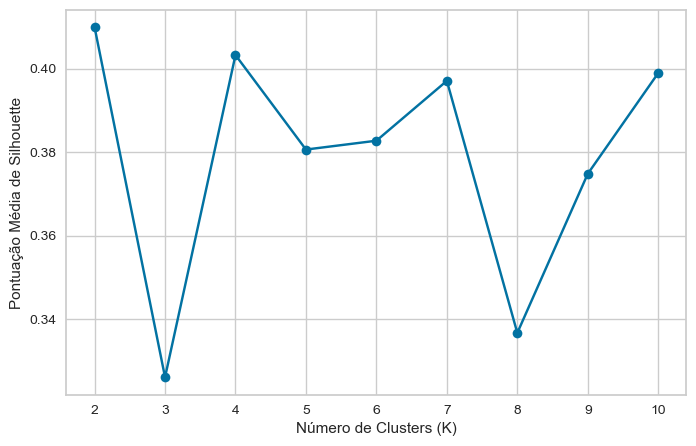

In [20]:
# silhueta para método kmeans
silhouette_scores = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=1987)
    cluster_labels = kmeans.fit_predict(mcdonalds_pad)
    silhouette_avg = silhouette_score(mcdonalds_pad, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plotar o gráfico de Silhouette
plt.figure(figsize=(8, 5))
plt.plot(K, silhouette_scores, 'bo-')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Pontuação Média de Silhouette')
plt.show()

### <code style="color:purple">Discussão </code> 

Vou investir na anáise de 4 grupos (decidi pela variabilidade do Elbow e pico do Silhueta).

C:\Users\adria\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


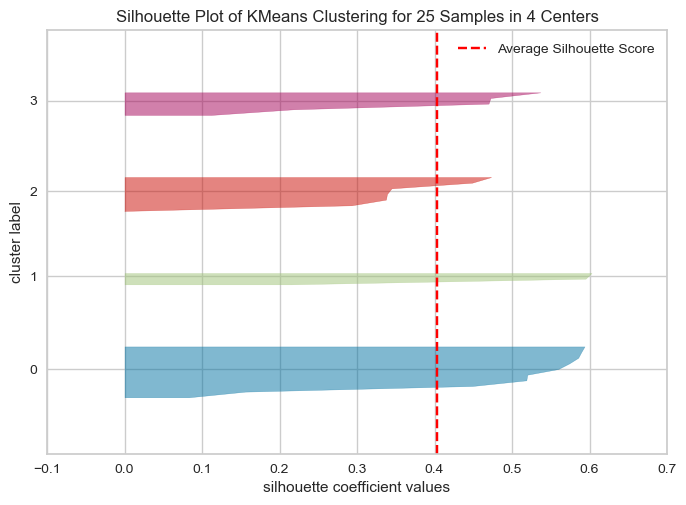

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 25 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [21]:
#observando a silhueta ponto a ponto com a escolha de 5 grupos
# Ajustar o modelo KMeans
kmeans = KMeans(n_clusters=4, random_state=1987)
model = kmeans.fit(mcdonalds_pad)

# Criar o visualizador Silhouette
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

# Gerar o gráfico
visualizer.fit(mcdonalds_pad)  
visualizer.show()    

In [22]:
# adicionando a marcação dos grupos na base padronizada e na original
mcdonalds_pad['cluster_kmeans'] = kmeans.labels_
mcdonalds['cluster_kmeans'] = kmeans.labels_

In [23]:
#calculando estatísticas descritivas da base original, conforme os cluster criados

#retirei as variaveis categorias (não faz sentido fazer média com elas) e pedi o describe
grouped = mcdonalds.groupby('cluster_kmeans').describe()
#pedi para transpor a tabela para poder visualizar melhor a saída
grouped_transposed = grouped.stack(level=0).reset_index()
#mudei o nome da varival level_1 para variavels
grouped_transposed = grouped_transposed.rename(columns={'level_1': 'variavel'})
#determinei a ordem que gostaria de ver na tabela
ordered_columns = ['cluster_kmeans', 'variavel', 'count', 'min', '25%', '50%', '75%', 'max', 'mean', 'std']
grouped_transposed = grouped_transposed[ordered_columns]
grouped_transposed
#adicionei cor nas linhas da tabela para ficar mais fácil visualizar
def color_rows(row):
    if row['cluster_kmeans'] == 0:
        return ['background-color: #A1CAF1'] * len(row)  # azul clarinho
    elif row['cluster_kmeans'] == 1:
        return ['background-color: #FDFD96'] * len(row)  # amarelo clarinho
    elif row['cluster_kmeans'] == 2:
        return ['background-color: #FFB347'] * len(row)  # laranja clarinho
    elif row['cluster_kmeans'] == 3:
        return ['background-color: #B19CD9'] * len(row)  # roxo clarinho
    elif row['cluster_kmeans'] == 4:
        return ['background-color: #77DD77'] * len(row)  # verde clarinho
styled_table = grouped_transposed.style.apply(color_rows, axis=1)
#ptonto
styled_table

C:\Users\adria\AppData\Local\Temp\ipykernel_36464\1911586011.py:6: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  grouped_transposed = grouped.stack(level=0).reset_index()


,cluster_kmeans,variavel,count,min,25%,50%,75%,max,mean,std
0,0,Calcio,10.000000,58.000000,89.000000,164.500000,172.000000,175.000000,136.400000,50.091472
1,0,Carboidratos,10.000000,29.000000,31.000000,32.500000,33.750000,40.000000,33.100000,3.478505
2,0,Colesterol,10.000000,11.000000,22.750000,34.500000,42.750000,83.000000,36.500000,20.156333
3,0,Ferro,10.000000,0.770000,0.815000,3.450000,3.975000,4.200000,2.639000,1.613935
4,0,Fibra Alimentar,10.000000,1.100000,1.800000,1.900000,2.800000,3.300000,2.130000,0.768910
5,0,Gorduras Saturadas,10.000000,2.100000,3.575000,4.550000,5.600000,7.000000,4.580000,1.451283
6,0,Gorduras Totais,10.000000,9.300000,14.500000,16.000000,16.750000,25.000000,16.130000,4.252071
7,0,Gorduras Trans,10.000000,0.100000,0.125000,0.300000,0.400000,0.400000,0.270000,0.133749
8,0,Proteinas,10.000000,13.000000,14.000000,16.500000,18.750000,39.000000,18.200000,7.699928
9,0,Sodio,10.000000,542.000000,775.000000,858.500000,1017.500000,1151.000000,867.100000,193.858167


C:\Users\adria\AppData\Local\Temp\ipykernel_36464\17097392.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=ax, x='Grupo', y=var, data=mcdonalds_combined, palette='Set1', order=order)
C:\Users\adria\AppData\Local\Temp\ipykernel_36464\17097392.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=ax, x='Grupo', y=var, data=mcdonalds_combined, palette='Set1', order=order)
C:\Users\adria\AppData\Local\Temp\ipykernel_36464\17097392.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=ax, x='Grupo', y=var, data=mcdonalds_combined, pal

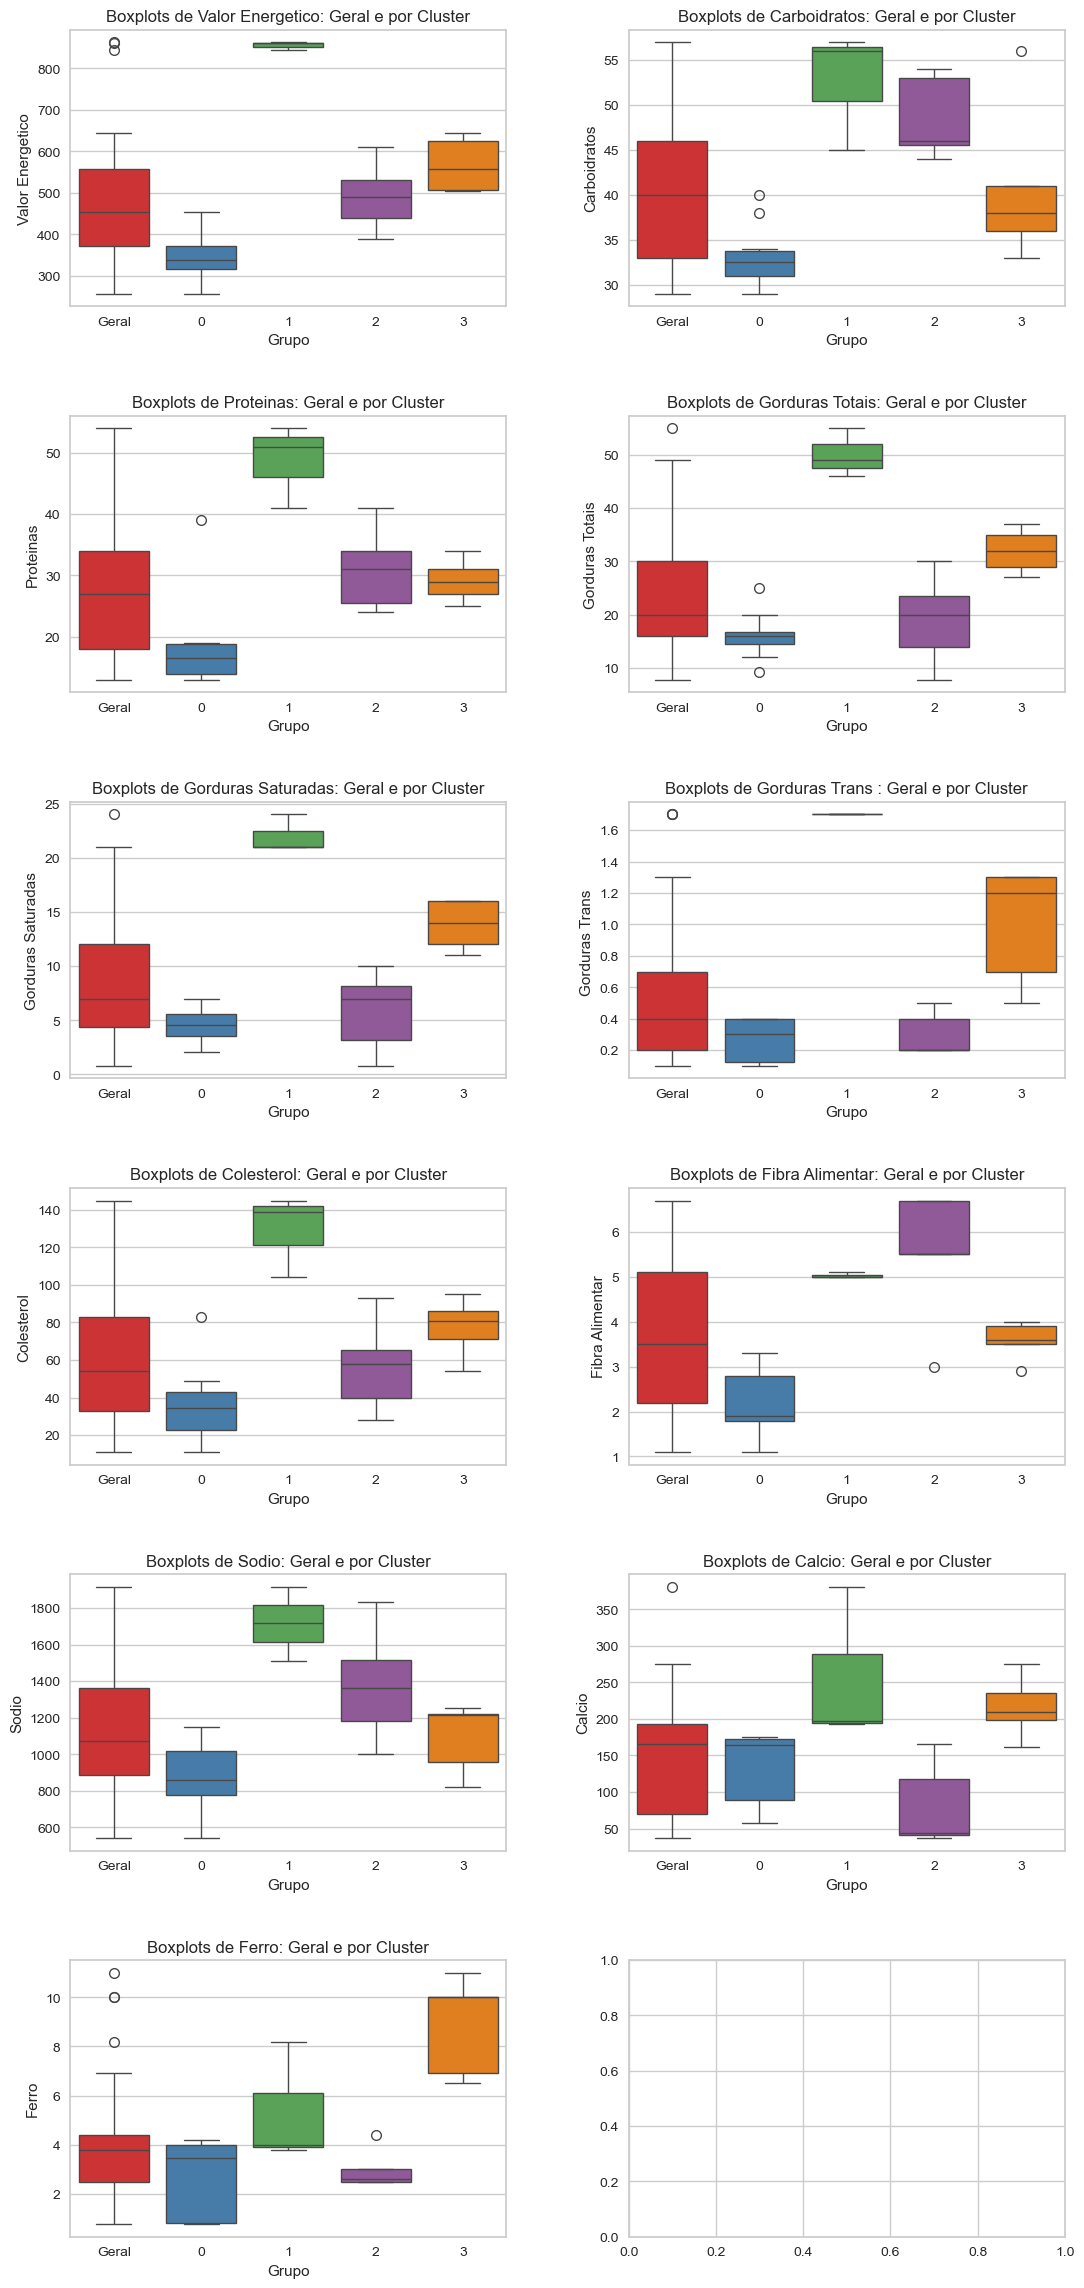

In [24]:
# Aumentar o tamanho da saída das células e evitar a barra de rolagem
display(HTML("""
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height: none !important;
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>
"""))

vars_analise = ['Valor Energetico', 'Carboidratos', 'Proteinas', 'Gorduras Totais',
       'Gorduras Saturadas', 'Gorduras Trans ', 'Colesterol',
       'Fibra Alimentar', 'Sodio', 'Calcio', 'Ferro']

# Definir quantos gráficos por linha (exemplo: 2)
graficos_por_linha = 2
# Calcular o número de linhas necessárias
num_linhas = -(-len(vars_analise) // graficos_por_linha)  
# Criar figura de subplots
fig, axes = plt.subplots(num_linhas, graficos_por_linha, figsize=(12, 4 * num_linhas))
# Ajustar o layout dos subplots
fig.tight_layout(pad=5.0)

for i, var in enumerate(vars_analise):
    ax = axes[i // graficos_por_linha, i % graficos_por_linha]  # Seleciona a posição correta do subplot
    
    # Criar uma nova coluna 'Grupo' que mantém os clusters e adiciona 'Geral' apenas para a plotagem
    mcdonalds['Grupo'] = mcdonalds['cluster_kmeans'].astype(str)
    
    # Criar uma cópia temporária para o grupo 'Geral' contendo todas as observações
    mcdonalds_geral = mcdonalds.copy()
    mcdonalds_geral['Grupo'] = 'Geral'
    
    # Concatenar os dados para garantir que 'Geral' contenha todos os dados e os clusters fiquem separados
    mcdonalds_combined = pd.concat([mcdonalds, mcdonalds_geral])
    
    # Definir a ordem das categorias com 'Geral' na primeira posição
    order = ['Geral'] + sorted(mcdonalds['cluster_kmeans'].unique().astype(str))
    
    # Plotar o boxplot geral e por cluster no subplot
    sns.boxplot(ax=ax, x='Grupo', y=var, data=mcdonalds_combined, palette='Set1', order=order)
    
    # Ajustar o título e rótulos
    ax.set_title(f'Boxplots de {var}: Geral e por Cluster')
    ax.set_xlabel('Grupo')
    ax.set_ylabel(var)

plt.show()

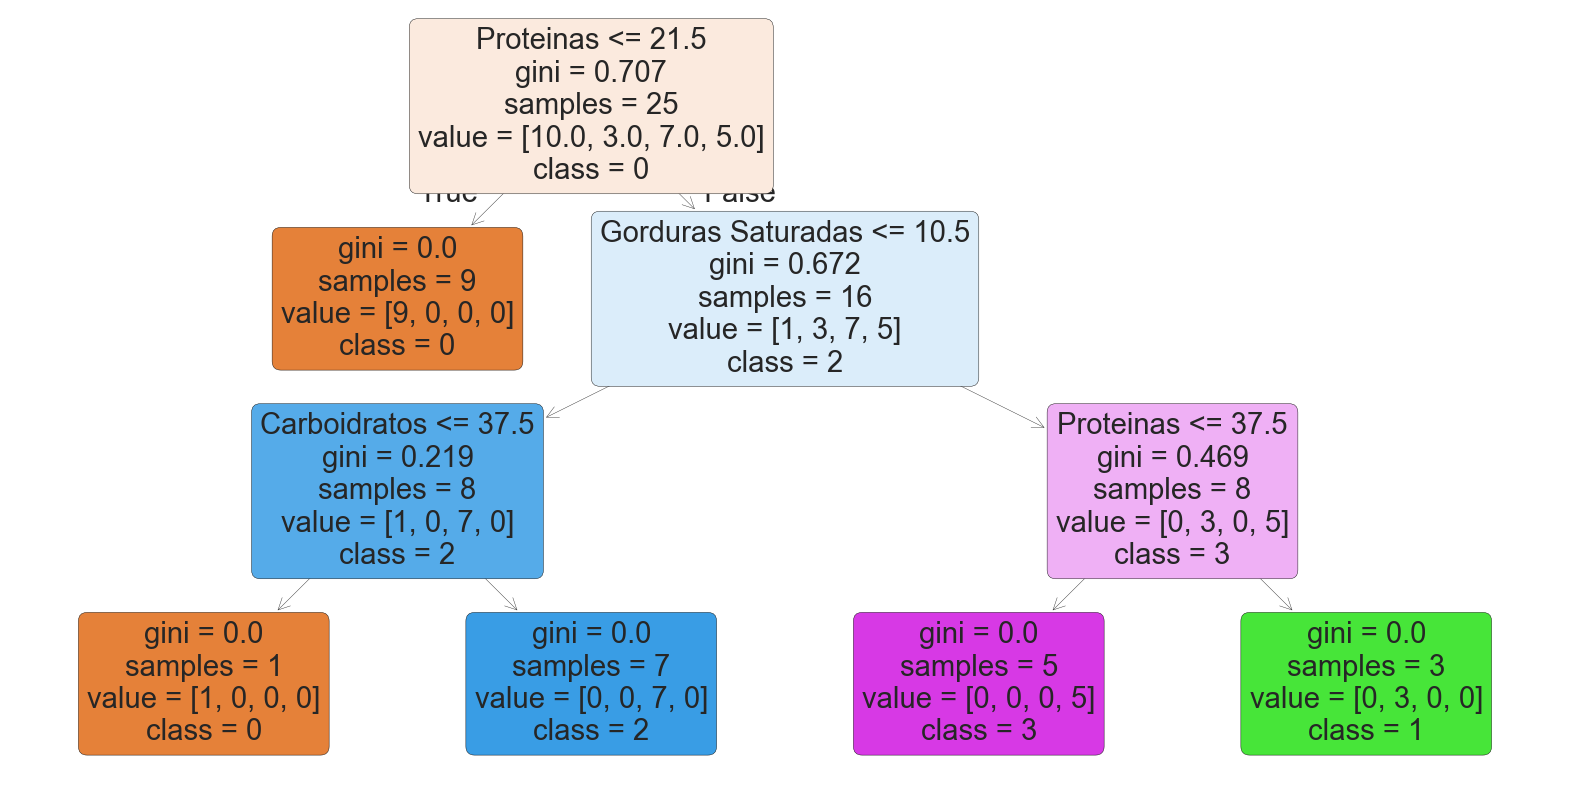

In [25]:
# Carregando a base de dados
# Supondo que sua base de dados já está carregada em um DataFrame chamado mcdonalds
# X são as variáveis preditoras e Y é o target 'cluster_kmeans'
X = mcdonalds[['Valor Energetico', 'Carboidratos', 'Proteinas', 'Gorduras Totais',
       'Gorduras Saturadas', 'Gorduras Trans ', 'Colesterol',
       'Fibra Alimentar', 'Sodio', 'Calcio', 'Ferro']]
y = mcdonalds['cluster_kmeans']

# Criando o modelo de árvore de decisão
arvore_decisao = DecisionTreeClassifier(random_state=42)
arvore_decisao.fit(X, y)

# Visualizando a árvore de decisão
plt.figure(figsize=(20, 10))  # Definindo o tamanho da figura
tree.plot_tree(arvore_decisao, feature_names=X.columns, class_names=[str(i) for i in set(y)], filled=True, rounded=True)
plt.show()

In [ ]:
vars_analise = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']

# Definir quantos gráficos por linha (exemplo: 2)
graficos_por_linha = 2
# Calcular o número de linhas necessárias
num_linhas = -(-len(vars_analise) // graficos_por_linha)  
# Criar figura de subplots
fig, axes = plt.subplots(num_linhas, graficos_por_linha, figsize=(12, 4 * num_linhas))
# Ajustar o layout dos subplots
fig.tight_layout(pad=5.0)

for i, var in enumerate(vars_analise):
    ax = axes[i // graficos_por_linha, i % graficos_por_linha]  # Seleciona a posição correta do subplot
    
    # Criar uma nova coluna 'Grupo' que mantém os clusters e adiciona 'Geral' apenas para a plotagem
    wholesale_customers['Grupo'] = wholesale_customers['cluster'].astype(str)
    
    # Criar uma cópia temporária para o grupo 'Geral' contendo todas as observações
    wholesale_customers_geral = wholesale_customers.copy()
    wholesale_customers_geral['Grupo'] = 'Geral'
    
    # Concatenar os dados para garantir que 'Geral' contenha todos os dados e os clusters fiquem separados
    wholesale_customers_combined = pd.concat([wholesale_customers, wholesale_customers_geral])
    
    # Definir a ordem das categorias com 'Geral' na primeira posição
    order = ['Geral'] + sorted(wholesale_customers['cluster'].unique().astype(str))
    
    # Plotar o boxplot geral e por cluster no subplot
    sns.boxplot(ax=ax, x='Grupo', y=var, data=wholesale_customers_combined, palette='Set1', order=order)
    
    # Ajustar o título e rótulos
    ax.set_title(f'Boxplots de {var}: Geral e por Cluster')
    ax.set_xlabel('Grupo')
    ax.set_ylabel(var)